研究で使用するように修正したコード類

**このプログラムは学習用（事前学習モデルのファインチューニング用）なので注意。実行はまた別のファイル**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           83Gi       1.1Gi        78Gi       1.0Mi       3.4Gi        81Gi
Swap:            0B          0B          0B


推論手法が2つある。
パイプラインとトーカナイザー。
0412ゼミに向けて行なったのはパイプラインだが、トーカナイザーの方が圧倒的に精度が上がるらしいので、今後に向けて今後に向けて試してみる。

https://dev.classmethod.jp/articles/huggingface-jp-text-classification/

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 3000
    })
})

In [ ]:
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
train_df.head(5)
train_df

,text,source,label
0,普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...,amazon_reviews_multi,2
1,十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...,amazon_reviews_multi,2
2,見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...,amazon_reviews_multi,2
3,よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...,amazon_reviews_multi,2
4,プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...,amazon_reviews_multi,2
...,...,...,...
119995,初孫の為に購入しました。近所におもちゃ屋さんがなく、ベビー服のお店にあるかと思ったのですが、...,amazon_reviews_multi,0
119996,よかったです！見た目も可愛い！ラインが入っているのが特に気に入りました。シンプル可愛い感じですね。,amazon_reviews_multi,0
119997,美味しい料理が、ポイントを押さえて、できます。イタリアンを作ってみたい…けど、難しそうと思っ...,amazon_reviews_multi,0
119998,取り付け簡単 値段も安い 明るい,amazon_reviews_multi,0


In [ ]:
train_df.value_counts(["source", "label"])

source                label
amazon_reviews_multi  0        40000
                      1        40000
                      2        40000
dtype: int64

In [ ]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

In [ ]:
def label_int2str(x):
	return dataset["train"].features["label"].int2str(x)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,text,source,label,label_name
0,普段使いとバイクに乗るときのブーツ兼用として購入しました。見た目や履き心地は良いです。 しか...,amazon_reviews_multi,2,negative
1,十分な在庫を用意できない販売元も悪いですが、Amazonやら楽⚪︎が転売を認めちゃってるのが...,amazon_reviews_multi,2,negative
2,見た目はかなりおしゃれで気に入りました。2、3回持ち歩いた後いつも通りゼンマイを巻いていたら...,amazon_reviews_multi,2,negative
3,よくある部分での断線はしませんでした ただiphoneとの接続部で接触不良、折れました ip...,amazon_reviews_multi,2,negative
4,プラモデルの塗装剥離に使う為に購入 届いて早速使ってみた 結果 １ヶ月経っても未だに剥離出来...,amazon_reviews_multi,2,negative


In [ ]:
dataset.reset_format()

In [ ]:
!pip install fugashi
!pip install ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.3/613.3 kB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 83.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556721 sha256=ff4b186c290011304ef847bd666571e921328b441a79f0eb937c3b3ee6a793cb
  Stored in directory: /root/.cache/pip/wheels/a0/9e/13/a63ab80684c3bd6305fe2bded26ac5f2c72ee1cb07a747994d
Successfully built ipadic


In [ ]:
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
sample_text = "渋滞大好き" #['positive']

In [ ]:
sample_text_encoded = tokenizer(sample_text)
print(sample_text_encoded)

{'input_ids': [2, 10427, 16489, 3], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

['[CLS]', '渋滞', '大好き', '[SEP]']


In [ ]:
decode_text = tokenizer.convert_tokens_to_string(tokens)
print(decode_text)

[CLS] 渋滞 大好き [SEP]


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
  
tokenizer.model_max_length

512

In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

dataset_encoded

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 120000
    })
    validation: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
    test: Dataset({
        features: ['text', 'source', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3000
    })
})

In [ ]:
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T

,input_ids,attention_mask,tokens
0,2,1,[CLS]
1,9406,1,普段
2,3276,1,使い
3,13,1,と
4,10602,1,バイク
...,...,...,...
507,0,0,[PAD]
508,0,0,[PAD]
509,0,0,[PAD]
510,0,0,[PAD]


In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

In [ ]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           83Gi       3.3Gi        73Gi        14Mi       7.0Gi        79Gi
Swap:            0B          0B          0B


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "sample-text-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2, #エポックば
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()
# ここの学習が無料だとできないので、課金して実行した。でも一回やればモデルが保存されるのでやらなくていいはず。

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.472500,0.399768,0.844333,0.842920
2,0.340600,0.417620,0.844000,0.842322


TrainOutput(global_step=15000, training_loss=0.40653889973958335, metrics={'train_runtime': 5808.5174, 'train_samples_per_second': 41.319, 'train_steps_per_second': 2.582, 'total_flos': 6.314722025472e+16, 'train_loss': 0.40653889973958335, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(dataset_encoded["validation"])

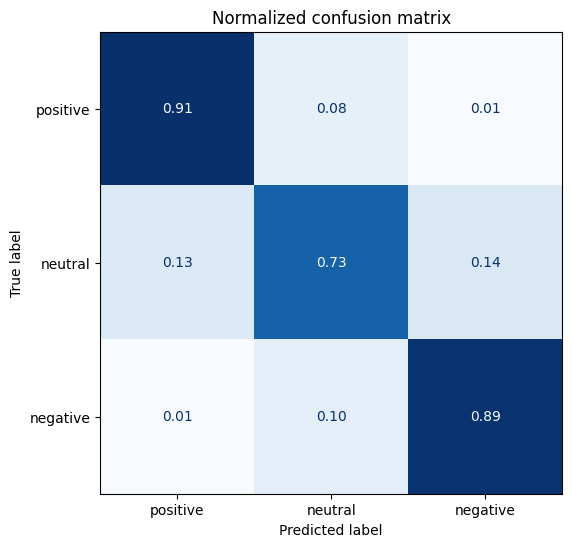

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["validation"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

In [ ]:
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

In [ ]:
trainer.save_model(f"/content/drive/MyDrive/sample-text-classification-bert")

In [ ]:
new_tokenizer = AutoTokenizer\
    .from_pretrained(f"/content/drive/MyDrive/sample-text-classification-bert")

new_model = (AutoModelForSequenceClassification
    .from_pretrained(f"/content/drive/MyDrive/sample-text-classification-bert")
    .to(device))

In [ ]:
inputs = new_tokenizer(sample_text, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

tensor([[ 1.1894,  0.2865, -2.0541]], device='cuda:0')

In [ ]:
y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
def id2label(x):
    return new_model.config.id2label[x]
y_dash = [id2label(x) for x in y_preds]
y_dash

['positive']

以下、コードまとめ

In [ ]:
# !pip install transformers
# !pip install datasets
# !pip install fugashi # tokenizerが内部で使用
# !pip install ipadic # tokenizerが内部で使用

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
import matplotlib.pyplot as plt
import numpy as np

# データセット取得
dataset = load_dataset("tyqiangz/multilingual-sentiments", "japanese")

# トークナイザの取得
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking")

# モデルの取得
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = dataset["train"].features["label"].num_classes
model = (AutoModelForSequenceClassification
    .from_pretrained("cl-tohoku/bert-base-japanese-whole-word-masking", num_labels=num_labels)
    .to(device))

# トークナイザ処理
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

# トレーニング準備
batch_size = 16 #バッチサイズ
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"sample-text-classification-distilbert"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2, #エポック
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
)

# 評価指標の定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# トレーニング
trainer = Trainer(
    model=model, args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

# 評価
preds_output = trainer.predict(dataset_encoded["validation"])

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["validation"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
plot_confusion_matrix(y_preds, y_valid, labels)

# ラベル情報付与
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

# 保存
trainer.save_model(f"/content/drive/MyDrive/sample-text-classification-bert")

# ロード
new_tokenizer = AutoTokenizer\
    .from_pretrained(f"/content/drive/MyDrive/sample-text-classification-bert")

new_model = (AutoModelForSequenceClassification
    .from_pretrained(f"/content/drive/MyDrive/sample-text-classification-bert")
    .to(device))

# サンプルテキストで推論
inputs = new_tokenizer(sample_text, return_tensors="pt")
new_model.eval()
with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
def id2label(x):
    return new_model.config.id2label[x]
y_dash = [id2label(x) for x in y_preds]
y_dash